# ICM2021 Finalist Team 2105298 source code

> Github: https://github.com/chaoers/icm2021-2105298-finalist

## 运行环境

In [22]:
# coding = utf-8

# use in jupyter notebook

%matplotlib inline

In [2]:
# import package

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import ward, fcluster, leaders
from scipy.cluster import hierarchy
from scipy.sparse import csr_matrix
import networkx as nx
import seaborn as sns
import math

sc = StandardScaler()

sns.set_style("ticks")

sns.despine()

<Figure size 432x288 with 0 Axes>

## 数据处理

In [3]:
# import source data

# source data
influenceFile = "./data/source_data/influence_data.csv"
fullFileRes = "./data/source_data/full_music_data.csv"
artistFile = "./data/source_data/data_by_artist.csv"

# result data
sixGenresFile = "./data/our_data/6data.csv" # 6类主流流派数值平均值

# read data
fullData = pd.read_csv(fullFileRes)
influenceData = pd.read_csv(influenceFile)
artistData = pd.read_csv(artistFile)

sixData = pd.read_csv(sixGenresFile)

In [4]:
# const genre group

genre = {'Pop/Rock':0, 'R&B;':1, 'Country':2, 'Jazz':3, 'Vocal':4, 'Latin':5, 'Classical':6, 'Folk':7, 'International':8, 'Blues':9, 'Reggae':10, 'Electronic':11, 'Easy Listening':12, 'Stage & Screen':13, 'Religious': 14, 'Comedy/Spoken':15, 'New Age':16, 'Avant-Garde':17, "Children's": 18, 'Unknown': 19}

In [5]:
# 去重 去unmaned 去nan

def cleanData(data):
    cleaned_data = data.drop_duplicates(keep='first',inplace=False).loc[:, ~data.columns.str.contains("^Unnamed")].dropna(axis=1,how='all').dropna(axis=0, how='any')
    return cleaned_data

In [6]:
# clean data

fullData = cleanData(fullData)
artistData = cleanData(artistData)
sixData = cleanData(sixData)


In [7]:
# 拼接流派数据到artistData

genre_res = pd.DataFrame(index=artistData.index, columns=['genre'])

for row_index, row in artistData['artist_id'].items():
    _tem = (influenceData.loc[(influenceData['influencer_id'] == row) | (influenceData['follower_id'] == row)]['influencer_main_genre'])
    if _tem.shape[0] != 0:
        genre_res['genre'][row_index] = _tem.iloc[0]
        
artistData_concated = pd.concat([artistData,genre_res],axis=1)
artistData_concated.to_csv('./res/artistData_concated.csv')

genre_res = pd.DataFrame(index=artistData.index, columns=['genre'])

In [8]:
# 拼接流派数据到fullData

for row_index, row in fullData['artists_id'].items():
    _tem = (influenceData.loc[(influenceData['influencer_id'] == eval(row)[0]) | (influenceData['follower_id'] == eval(row)[0])]['influencer_main_genre'])
    if _tem.shape[0] != 0:
        genre_res['genre'][row_index] = _tem.iloc[0]
        
fullData_concated = pd.concat([fullData,genre_res],axis=1)
fullData_concated.to_csv('./res/fullData_concated.csv')

In [9]:
# 下面使用的数据都是拼接流派之后的， 再次清洗数据

artistData = artistData_concated
fullData = fullData_concated

fullData = cleanData(fullData)
artistData = cleanData(artistData)

In [10]:
# change to numpy

fullData_np = pd.DataFrame(fullData, columns=fullData.iloc[:, 2:15].columns).drop(columns=['explicit']).to_numpy().astype(float)
artistData_np = artistData.drop(columns=['artist_name', 'artist_id', 'count', 'popularity', 'genre']).to_numpy().astype(float)
sixData_np = sixData.drop(columns=['leibie']).to_numpy().astype(float)

artistData.to_csv('./res/art_clear.csv')
pd.DataFrame(sc.fit_transform(artistData_np)).to_csv('./res/art_fit.csv')

## PCA 主成分分析

In [11]:
# PCA 主成分分析

def pca(XMat, k):
    m, n = np.shape(XMat)
    data_adjust = sc.fit_transform(XMat)           # 标准化
    covX = np.cov(data_adjust.T)                   # 协方差矩阵

    eigenValue, eigenVec = np.linalg.eig(covX)     # 所有特征值和特征向量
    
    eigValIndice=np.argsort(eigenValue)
    n_eigValIndice=eigValIndice[-1:-(k+1):-1]      # 最大n个
    n_eigVect=eigenVec[:,n_eigValIndice]
    n_eigVal=eigenValue[n_eigValIndice]
    finalData = np.dot(data_adjust, n_eigVect)     # 处理后的数据
    
    return finalData, n_eigVect, n_eigVal

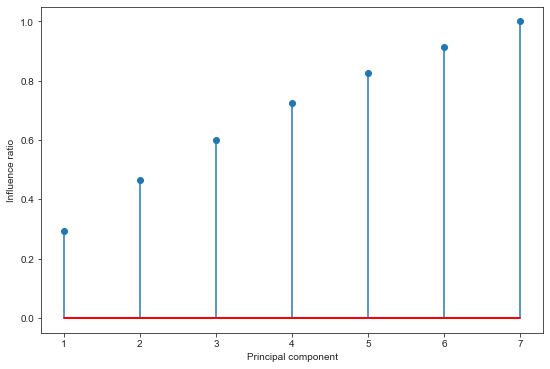

[2.88894172 1.70491617 1.31505106 1.2266716  0.99836972 0.88131636
 0.83558603]
[[-1.68016620e-01 -5.76248023e-01  4.75772328e-02  3.53342721e-01
  -1.31863806e-01 -3.18508644e-02  1.70273440e-01]
 [-5.22238332e-01  2.31683849e-01 -4.51697248e-02  4.47856330e-02
  -6.76291383e-02 -7.44106998e-02  5.59924688e-02]
 [-2.50617963e-01 -5.25706141e-01  3.65956027e-02  9.44524747e-02
  -8.52725759e-02  2.88487963e-01  2.87517346e-01]
 [-2.33002604e-01  1.81210982e-01 -1.38108328e-01 -2.69041591e-01
   1.24969326e-02  7.82418691e-01  1.93725789e-01]
 [-5.07321088e-01  1.08069313e-01 -5.07238186e-02 -2.98982947e-02
  -8.33901042e-03 -2.03567681e-01 -1.54906951e-01]
 [ 9.15884556e-04 -7.67547814e-02  9.82869448e-02 -6.28607148e-01
  -5.56077552e-02 -3.68328694e-01  6.49733032e-01]
 [-4.55418177e-02  1.77769668e-02 -4.55937952e-02  2.02749505e-01
   9.39136140e-01 -3.18523192e-02  2.63919261e-01]
 [ 4.69034805e-01 -2.06159005e-01  2.15076364e-01 -1.31728600e-01
   6.81434555e-02  1.64669520e-01 -

In [12]:
# 调用主成分分析

art_ver, art_vec, art_val  = pca(artistData_np, 7)

np.savetxt("./res/eigVect.txt",art_vec)
pd.DataFrame(art_ver).to_csv("./res/ver.csv")

a = art_val

a = a/sum(a)

for i in range(1, len(a)):
    a[i] = a[i] + a[i-1]

x = np.linspace(1, 7, 7)

plt.figure(figsize=(9, 6))

markerline, stemlines, baseline = plt.stem(x, a, '-')

plt.setp(baseline, color='r', linewidth=2)

plt.xticks(x)

plt.xlabel('Principal component')

plt.ylabel('Influence ratio')

plt.savefig('./img/PCA_line.jpg', dpi=600)

plt.show()

print(art_val)
print(art_vec)
print(art_ver)

In [13]:
# 主成分分析作图函数

def pca_draw2D(data, n_eigVect, columns=[ 'artist_name','artist_id', 'count', 'popularity', 'genre']):
    for i in range(6):
        _data = sc.fit_transform(np.dot(sc.fit_transform(data[data['genre'] == list (genre.keys()) [list (genre.values()).index (i)]].drop(columns=columns).to_numpy().astype(float)), n_eigVect))
        plt.scatter(_data[:,0], _data[:,1], edgecolor='none',
                alpha=0.5, cmap=plt.cm.get_cmap('Spectral', 10))

    # plt.xlim((-3, 3))
    # plt.ylim((-3, 3))

def pca_draw3D(data, n_eigVect, columns=[ 'artist_name','artist_id', 'count', 'popularity', 'genre']):
    
    ax = plt.subplot(111, projection='3d')
    for i in range(6):
        _data = sc.fit_transform(np.dot(sc.fit_transform(data[data['genre'] == list (genre.keys()) [list (genre.values()).index(i)]].drop(columns=columns).to_numpy().astype(float)), n_eigVect))
        ax.scatter(_data[:,0], _data[:,1], _data[:,2])
        
    # ax.set_zlim(-2, 2)
    # plt.xlim((-3, 3))
    # plt.ylim((-3, 3))

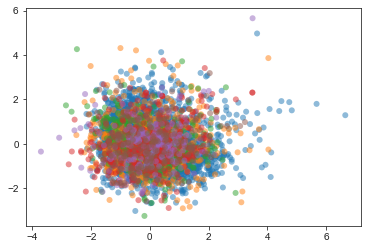

In [14]:
# 主成分分析作图

%matplotlib inline
pca_draw2D(artistData, art_vec)

# %matplotlib notebook


## 聚类算法

> 6类主要流派为我们人工筛选得到的

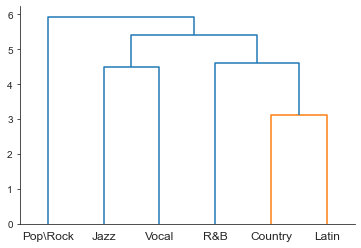

(6, 12)

In [25]:
%matplotlib inline

label_name = np.array(['Country','Jazz','Latin','Pop\Rock','R&B','Vocal'])

cluData = sc.fit_transform(sixData_np)

Z = hierarchy.linkage(cluData, method ='average',metric='euclidean')
hierarchy.dendrogram(Z, labels=label_name)
sns.despine()

plt.savefig('./img/6Data.jpg', dpi=600)
plt.show()

cluData.shape

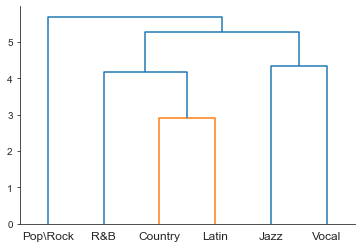

(6, 7)

In [16]:
%matplotlib inline

label_name = np.array(['Country','Jazz','Latin','Pop\Rock','R&B','Vocal'])
cluData = (np.dot(sc.fit_transform(sixData_np), art_vec))

Z = hierarchy.linkage(cluData, method ='average',metric='euclidean')
hierarchy.dendrogram(Z, labels=label_name)

sns.despine()

plt.savefig('./img/6Data_pac.jpg', dpi=600)
plt.show()

cluData.shape

In [17]:
# 距离矩阵函数
def disArr(ver):
    
    distA=pdist(ver,metric='euclidean')
    # 将distA数组变成一个矩阵
    distB = squareform(distA)
    
        # 计算组内和组件平均距离
    dis_arr = np.zeros((6, 6))

    for i in range(6):
        for j in range(i+1, 6):
            _row = np.flatnonzero(artistData['genre'] == list (genre.keys()) [list (genre.values()).index (i)])
            _col = np.flatnonzero(artistData['genre'] == list (genre.keys()) [list (genre.values()).index (j)])
            _data = distB[_row, :]
            _data = _data[:, _col]
            dis_sum = np.sum(_data)/(_row.shape[0] * _col.shape[0])
            dis_arr[i, j] = dis_sum

    dis_same = np.zeros((6, 6))
    for i in range(6):
        _row = np.flatnonzero(artistData['genre'] == list (genre.keys()) [list (genre.values()).index (i)])
        _data = distB[_row,:]
        _data = _data[:, _row]
        dis_sum = np.sum(_data)/(_row.shape[0] * _row.shape[0])
        dis_same[i, i] = dis_sum

    dis_arr = pd.DataFrame(dis_same) + pd.DataFrame(dis_arr)
    
    return dis_arr, distB

In [18]:
ver = (np.dot(sc.fit_transform(artistData_np), art_vec))

# 距离矩阵计算
ver_dis_arr, ver_disB =  disArr(ver)

pd.DataFrame.to_csv(ver_dis_arr, './res/dis_arr_7_dim.csv')

_data_dis = sc.fit_transform(artistData_np)

data_dis_arr, data_disB = disArr(_data_dis)

pd.DataFrame.to_csv(data_dis_arr, './res/dis_arr.csv')

print(ver_dis_arr)
print(data_dis_arr)

         0         1         2         3         4         5
0  3.61054  3.780531  3.574001  4.804366  4.554332  3.812649
1  0.00000  3.494771  3.459513  4.585476  4.371504  3.523012
2  0.00000  0.000000  2.949228  4.418006  3.833693  3.366532
3  0.00000  0.000000  0.000000  4.089081  4.370741  4.518321
4  0.00000  0.000000  0.000000  0.000000  3.495254  4.248386
5  0.00000  0.000000  0.000000  0.000000  0.000000  3.475635
          0         1         2         3         4         5
0  4.073627  4.219618  3.986226  5.261635  4.935736  4.278945
1  0.000000  3.925867  3.854881  5.051231  4.734049  4.002608
2  0.000000  0.000000  3.337533  4.842191  4.191502  3.795095
3  0.000000  0.000000  0.000000  4.652109  4.839420  4.975161
4  0.000000  0.000000  0.000000  0.000000  3.885127  4.632725
5  0.000000  0.000000  0.000000  0.000000  0.000000  3.920471


### 60类聚类

> 60类指6个流派再通过年代进行划分分为60类

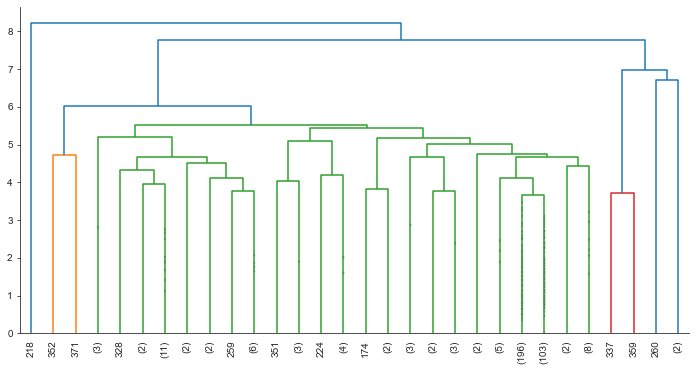

In [24]:
# 60类聚类

# result data
# _n_art_data 为 n 年代的艺术家id
_60_art_data = np.genfromtxt("./data/our_data/60_ar.csv", dtype="int")
_70_art_data = np.genfromtxt("./data/our_data/70_ar.csv", dtype="int")
_80_art_data = np.genfromtxt("./data/our_data/80_ar.csv", dtype="int", encoding='utf-8')


artistData['artist_id'] = artistData['artist_id'].astype('int')

_60_art =  artistData[artistData['artist_id'].isin(_60_art_data)]
_70_art =  artistData[artistData['artist_id'].isin(_70_art_data)]
_80_art =  artistData[artistData['artist_id'].isin(_80_art_data)]

_60_art_np = _60_art.drop(columns=['artist_name', 'artist_id', 'count', 'popularity', 'genre']).to_numpy().astype(float)
_70_art_np = _70_art.drop(columns=['artist_name', 'artist_id', 'count', 'popularity', 'genre']).to_numpy().astype(float)
_80_art_np = _80_art.drop(columns=['artist_name', 'artist_id', 'count', 'popularity', 'genre']).to_numpy().astype(float)

_60_art_np = np.dot(sc.fit_transform(_60_art_np), art_vec)
_70_art_np = np.dot(sc.fit_transform(_70_art_np), art_vec)
_80_art_np = np.dot(sc.fit_transform(_80_art_np), art_vec)

# _60_art_np = sc.fit_transform(_60_art_np)
# _70_art_np = sc.fit_transform(_60_art_np)


plt.figure(figsize=(12, 6))

Z = hierarchy.linkage(_60_art_np, method ='average',metric='euclidean')

hierarchy.dendrogram(Z, leaf_rotation=90., leaf_font_size=10., show_contracted=True, truncate_mode='lastp')

sns.despine()
plt.savefig('./img/60_clu.jpg', dpi = 600)

plt.show()

_60_art.to_csv('./res/_60_art.csv')


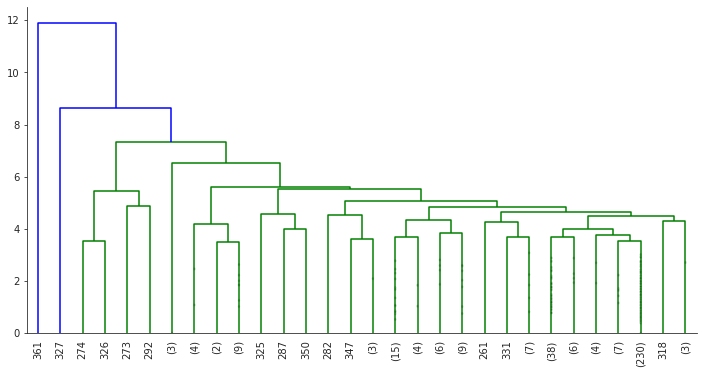

In [ ]:
plt.figure(figsize=(12, 6))

Z = hierarchy.linkage(_70_art_np, method ='average',metric='euclidean')

hierarchy.dendrogram(Z, leaf_rotation=90., leaf_font_size=10., show_contracted=True, truncate_mode='lastp')

sns.despine()
plt.savefig('./img/70_clu.jpg', dpi = 600)

plt.show()

_70_art.to_csv('./res/_70_art.csv')

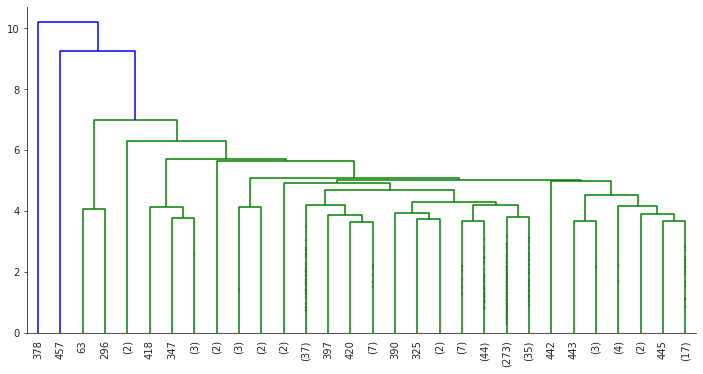

In [ ]:
plt.figure(figsize=(12, 6))

Z = hierarchy.linkage(_80_art_np, method ='average',metric='euclidean')

hierarchy.dendrogram(Z, leaf_rotation=90., leaf_font_size=10., show_contracted=True, truncate_mode='lastp')

sns.despine()
plt.savefig('./img/80_clu.jpg', dpi = 600)

plt.show()

_80_art.to_csv('./res/_80_art.csv')

In [27]:
T = fcluster(Z, 3, criterion='distance')
T

array([3, 1, 4, 6, 5, 2], dtype=int32)

### 聚类树图

最后论文页数超了删掉了，有点可惜

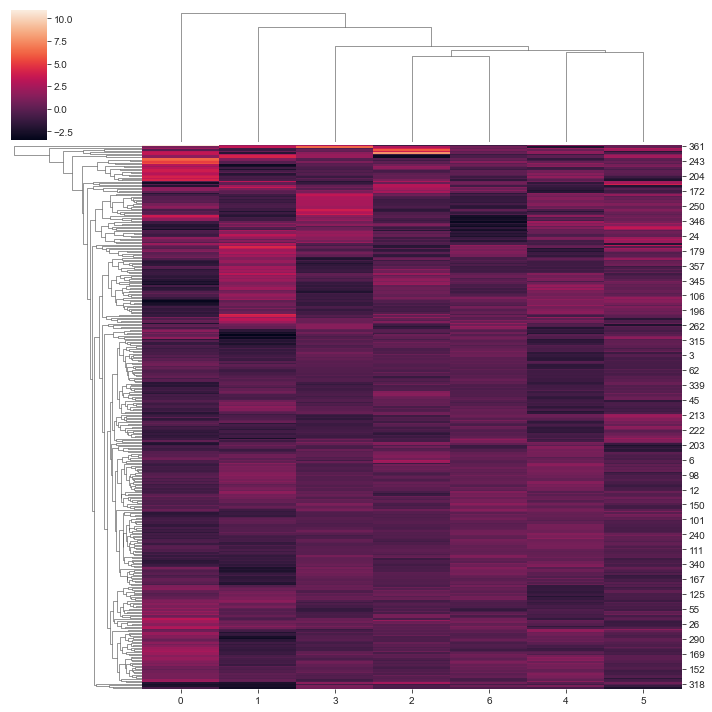

In [28]:
# 聚类树图

# plt.figure(figsize=(50, 50))
g = sns.clustermap(_70_art_np)
plt.show()

In [29]:
pd.DataFrame(Z)

0    1         2    3
0  0.0  2.0  3.105656  2.0
1  1.0  5.0  4.495455  2.0
2  4.0  6.0  4.601386  3.0
3  7.0  8.0  5.418890  5.0
4  3.0  9.0  5.934960  6.0

## 6个主要流派的12类特征展示

In [30]:
fullData_6 = fullData[(fullData['genre'] == 'Pop/Rock') | (fullData['genre'] == 'R&B;') | (fullData['genre'] == 'Country') | (fullData['genre'] == 'Jazz') | (fullData['genre'] == 'Vocal') | (fullData['genre'] == 'Latin')]
fullData_6

artist_names artists_id  danceability  energy  valence    tempo  \
3     ["Alexander O'Neal"]   [625201]         0.761   0.702    0.850  104.773   
4     ["Alexander O'Neal"]   [625201]         0.661   0.828    0.902  115.078   
5     ["Alexander O'Neal"]   [625201]         0.719   0.650    0.953  105.141   
6     ["Alexander O'Neal"]   [625201]         0.649   0.245    0.273  112.709   
7     ["Alexander O'Neal"]   [625201]         0.701   0.715    0.735  101.515   
...                    ...        ...           ...     ...      ...      ...   
5849         ['Aerosmith']   [604852]         0.324   0.869    0.323  127.908   
5850         ['Aerosmith']   [604852]         0.371   0.904    0.569   95.850   
5851         ['Aerosmith']   [604852]         0.317   0.746    0.244  119.216   
5852         ['Aerosmith']   [604852]         0.752   0.830    0.923  105.793   
5853         ['Aerosmith']   [604852]         0.329   0.769    0.252  139.347   

      loudness  mode   key  acousticness  instrumentalness  liveness  \
3       -8.523   1.0   7.0       0.10800          0.000031    0.0935   
4      -12.673   0.0  11.0       0.27600          0.000001    0.2870   
5      -12.947   0.0   7.0       0.01030          0.000044    0.1330   
6      -17.585   1.0  11.0       0.49600          0.000000    0.1740   
7      -14.999   0.0  11.0       0.06000          0.000000    0.3540   
...        ...   ...   ...           ...               ...       ...   
5849   -10.112   1.0   7.0       0.13100          0.112000    0.7580   
5850    -9.861   1.0   2.0       0.01000          0.000012    0.2050   
5851    -9.929   0.0   5.0       0.10800          0.000000    0.1720   
5852    -3.291   0.0   6.0       0.01650          0.000032    0.0691   
5853    -3.883   1.0   0.0       0.00791          0.000884    0.4060   

      speechiness  explicit  duration_ms  popularity    year release_date  \
3          0.0389       0.0     304427.0        34.0  1991.0     1/1/1991   
4          0.0390       0.0     264933.0        37.0  1987.0    7/29/1987   
5          0.0265       0.0     277773.0        34.0  1987.0    7/29/1987   
6          0.0286       0.0     312733.0        29.0  1987.0    7/29/1987   
7          0.0291       0.0     241107.0        32.0  1987.0    7/29/1987   
...           ...       ...          ...         ...     ...          ...   
5849       0.0620       0.0     265293.0        22.0  1978.0    10/1/1978   
5850       0.0546       0.0     221040.0        24.0  1985.0     1/1/1985   
5851       0.0600       0.0     223600.0        24.0  1985.0     1/1/1985   
5852       0.0550       0.0     309200.0        21.0  1986.0    5/15/1986   
5853       0.0332       0.0     356533.0        31.0  1994.0     1/1/1994   

                                  song_title (censored)     genre  
3                                          All True Man      R&B;  
4                  (What Can I Say) To Make You Love Me      R&B;  
5                                            The Lovers      R&B;  
6                                       Crying Overtime      R&B;  
7                                               Hearsay      R&B;  
...                                                 ...       ...  
5849  Back in the Saddle - Live at Market Square Are...  Pop/Rock  
5850                                            The Hop  Pop/Rock  
5851                                           Darkness  Pop/Rock  
5852                    Walk This Way (feat. Aerosmith)  Pop/Rock  
5853                                            Amazing  Pop/Rock  

[3927 rows x 20 columns]

/usr/local/anaconda3/envs/graph/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/anaconda3/envs/graph/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/anaconda3/envs/graph/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

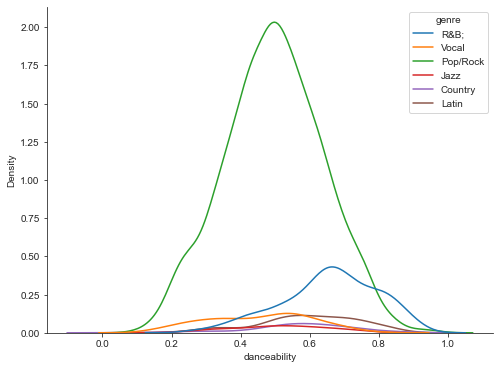

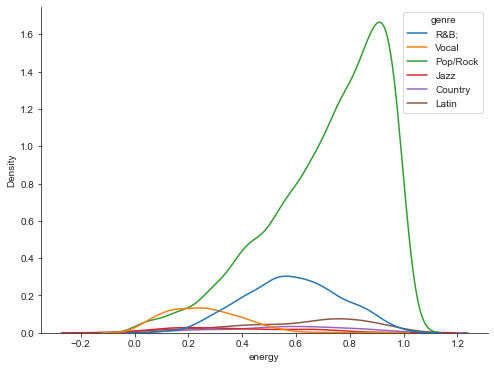

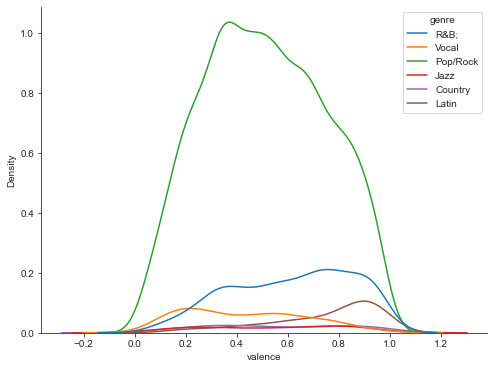

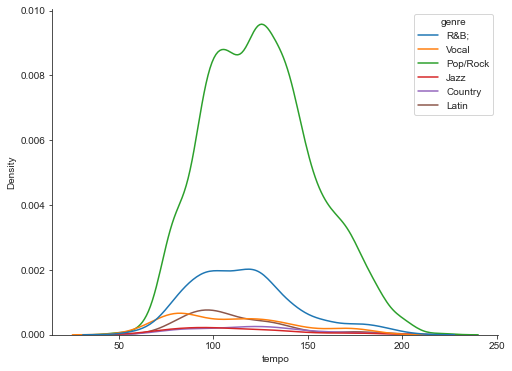

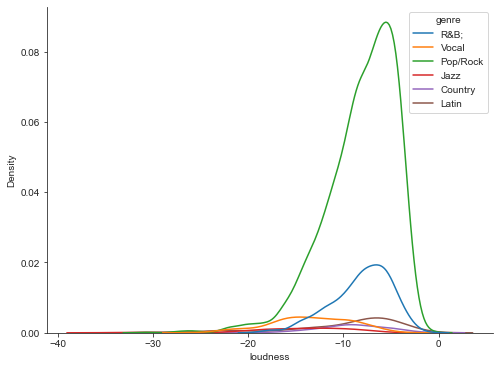

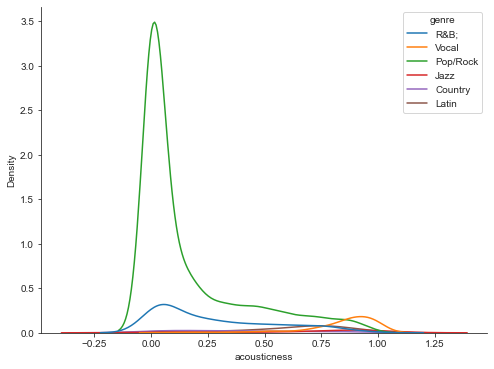

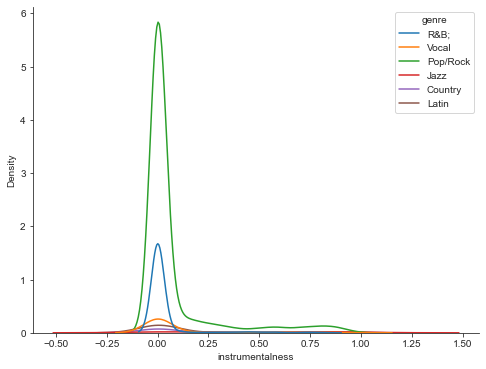

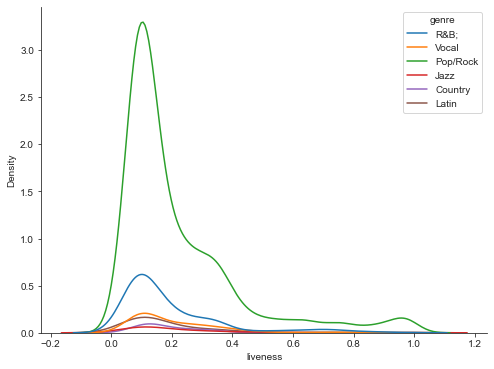

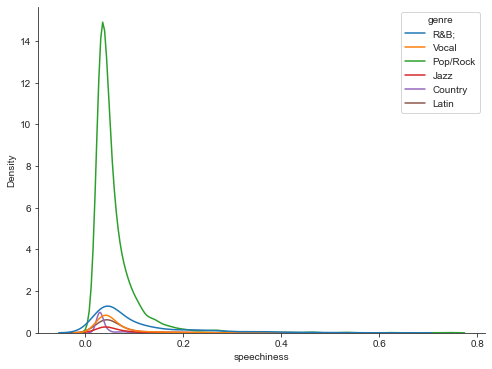

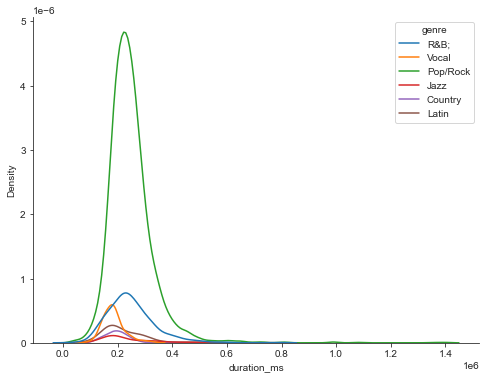

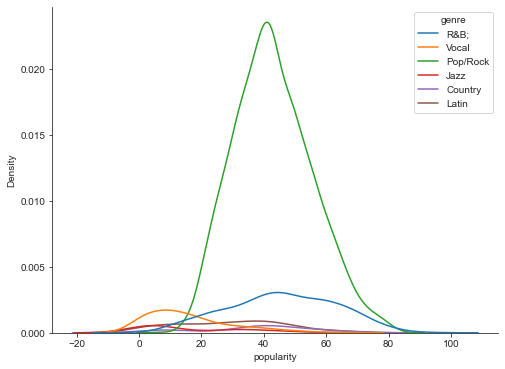

In [31]:
fullData_6['danceability'] = fullData_6['danceability'].astype('float')

plt.figure(figsize=(8, 6))


sns.kdeplot(
   data=fullData_6, x='danceability', hue='genre',
#    fill=True, common_norm=False, palette="bright",
#    alpha=.2, linewidth=0,
)
sns.despine()
plt.savefig('./img/danceability.jpg', dpi=600)

plt.figure(figsize=(8, 6))

fullData_6['energy'] = fullData_6['energy'].astype('float')


sns.kdeplot(

   data=fullData_6, x='energy', hue='genre',
#     fill=True, common_norm=False, palette="crest",
#    alpha=.3, linewidth=0,
)
sns.despine()
plt.savefig('./img/energy.jpg', dpi=600)

fullData_6['valence'] = fullData_6['valence'].astype('float')

plt.figure(figsize=(8, 6))

sns.kdeplot(
   data=fullData_6, x='valence', hue='genre',
#    fill=True, common_norm=False, palette="crest",
#    alpha=.3, linewidth=0,
)
sns.despine()
plt.savefig('./img/valence.jpg', dpi=600)

fullData_6['tempo'] = fullData_6['tempo'].astype('float')

plt.figure(figsize=(8, 6))

sns.kdeplot(
   data=fullData_6, x='tempo', hue='genre',
#    fill=True, common_norm=False, palette="crest",
#    alpha=.3, linewidth=0,
)
sns.despine()
plt.savefig('./img/tempo.jpg', dpi=600)


fullData_6['loudness'] = fullData_6['loudness'].astype('float')

plt.figure(figsize=(8, 6))

sns.kdeplot(
   data=fullData_6, x='loudness', hue='genre',
#    fill=True, common_norm=False, palette="crest",
#    alpha=.4, linewidth=0,
)
sns.despine()
plt.savefig('./img/loudness.jpg', dpi=600)

fullData_6['acousticness'] = fullData_6['acousticness'].astype('float')

plt.figure(figsize=(8, 6))

sns.kdeplot(
   data=fullData_6, x='acousticness', hue='genre',
#    fill=True, common_norm=False, palette="crest",
#    alpha=.4, linewidth=0,
)
sns.despine()
plt.savefig('./img/acousticness.jpg', dpi=600)

fullData_6['instrumentalness'] = fullData_6['instrumentalness'].astype('float')

plt.figure(figsize=(8, 6))

sns.kdeplot(
   data=fullData_6, x='instrumentalness', hue='genre',
#    fill=True, common_norm=False, palette="bright",
#    alpha=.4, linewidth=0,
)
sns.despine()
plt.savefig('./img/instrumentalness.jpg', dpi=600)

fullData_6['liveness'] = fullData_6['liveness'].astype('float')

plt.figure(figsize=(8, 6))

sns.kdeplot(
   data=fullData_6, x='liveness', hue='genre',
#    fill=True, common_norm=False, palette="crest",
#    alpha=.4, linewidth=0,
)
sns.despine()
plt.savefig('./img/liveness.jpg', dpi=600)

fullData_6['speechiness'] = fullData_6['speechiness'].astype('float')

plt.figure(figsize=(8, 6))

sns.kdeplot(
   data=fullData_6, x='speechiness', hue='genre',
#    fill=True, common_norm=False, palette="crest",
#    alpha=.4, linewidth=0,
)
sns.despine()
plt.savefig('./img/speechiness.jpg', dpi=600)

fullData_6['duration_ms'] = fullData_6['duration_ms'].astype('float')

plt.figure(figsize=(8, 6))

sns.kdeplot(
   data=fullData_6, x='duration_ms', hue='genre',
#    fill=True, common_norm=False, palette="crest",
#    alpha=.4, linewidth=0,
)
sns.despine()
plt.savefig('./img/duration_ms.jpg', dpi=600)

fullData_6['popularity'] = fullData_6['popularity'].astype('float')

plt.figure(figsize=(8, 6))

sns.kdeplot(
   data=fullData_6, x='popularity', hue='genre',
#    fill=True, common_norm=False, palette="crest",
#    alpha=.4, linewidth=0,
)
sns.despine()
plt.savefig('./img/popularity.jpg', dpi=600)




## 网络图

In [32]:
# 计算网络图邻接矩阵

graph = np.zeros((influenceData.shape[0], 2))

minYear = int(min(min(influenceData['influencer_active_start']), min(influenceData['follower_active_start'])))

minYear

maxYear = int(max(max(influenceData['influencer_active_start']), max(influenceData['follower_active_start'])))

for row_index, row  in influenceData.iterrows():
    # print(row_index, row['influencer_main_genre'])
    
    graph[row_index][0] = genre[row['influencer_main_genre']] + int((int(row['influencer_active_start']) - minYear)/10)* 20
    graph[row_index][1] = genre[row['follower_main_genre']] + int((int(row['follower_active_start']) - minYear)/10) * 20


### 全网络图作图

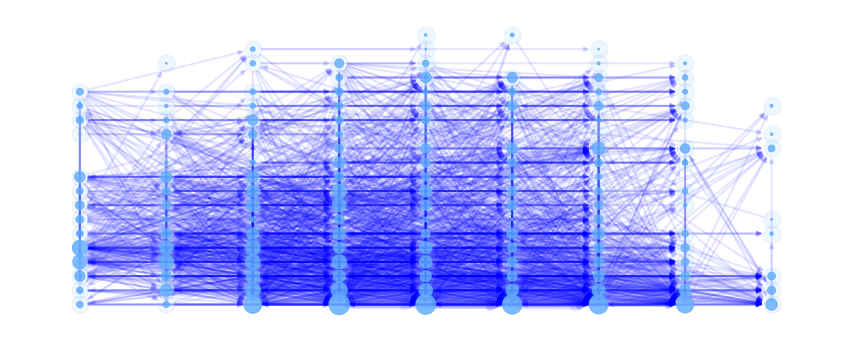

In [33]:
# 通过邻接矩阵作图

%matplotlib inline
graph = graph.astype(int)

G = nx.Graph()

G.clear()

row = np.array(graph[:, 0])
col = np.array(graph[:, 1])

data = np.ones((1, graph.shape[0])).reshape(-1)

n = max(max(row), max(col)) + 1

pos = {}

for i in range((maxYear - minYear + 10)*2):
    pos[i] = (i // 20, i % 20)

A = csr_matrix((data, (row, col)), shape=(n, n)).toarray()

A = np.where(A < 0, 0, A).astype('int')

G = nx.from_numpy_matrix(A, create_using=nx.DiGraph()) 

_be_d = dict(G.degree)

G.remove_nodes_from(list(nx.isolates(G)))

# G = G.to_directed()

color_list = [float(v['weight']*0.5) for (r,c,v) in G.edges(data=True)]

color_list = [int(((i/max(color_list))*8 + 2)) for i in color_list]

d = dict(G.degree)

plt.figure(figsize=(15, 6))


plt.axis("off")
# nx.draw(G, pos, node_color="#A0CBE2", edge_color="#aaaaaa")
nx.draw(G,
        pos,
        width=color_list,
        node_color="#60acfc",
        edge_color = 'b',
        alpha = 0.1
       )
nx.draw_networkx_nodes(G,pos, node_color="#60acfc",node_size=[v * 3 for v in d.values()], alpha=0.8)

plt.savefig('./img/all_network.jpg', dpi = 600)

plt.show() 

A_all = A

### 权重为50以上的网络图

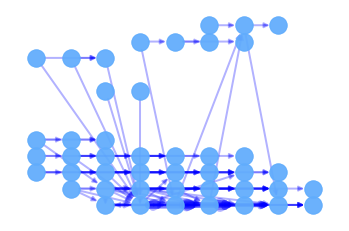

In [34]:
# 通过邻接矩阵作图

%matplotlib inline
graph = graph.astype(int)

G = nx.Graph()

G.clear()

row = np.array(graph[:, 0])
col = np.array(graph[:, 1])

data = np.ones((1, graph.shape[0])).reshape(-1)

n = max(max(row), max(col)) + 1

pos = {}

for i in range((maxYear - minYear + 10)*2):
    pos[i] = (i // 20, i % 20)

A = csr_matrix((data, (row, col)), shape=(n, n)).toarray()

A = np.where(A < 50, 0, A).astype('int')

G = nx.from_numpy_matrix(A, create_using=nx.DiGraph()) 

_be_d = dict(G.degree)

G.remove_nodes_from(list(nx.isolates(G)))

# G = G.to_directed()

color_list = [float(v['weight']*0.5) for (r,c,v) in G.edges(data=True)]

color_list = [int(((i/max(color_list))*8 + 2)) for i in color_list]

# d = dict(G.degree)

# plt.figure(figsize=(15, 6))


plt.axis("off")
# nx.draw(G, pos, node_color="#A0CBE2", edge_color="#aaaaaa")
nx.draw(G,
        pos,
        width=color_list,
        node_color="#60acfc",
        edge_color = 'b',
        alpha = 0.3
       )
nx.draw_networkx_nodes(G,pos, node_color="#60acfc",
#                        node_size=[v * 3 for v in d.values()],
                       alpha=0.9
                      )

plt.savefig('./img/all_network_50.jpg', dpi = 600)

plt.show() 

### 选取几个示例点作图

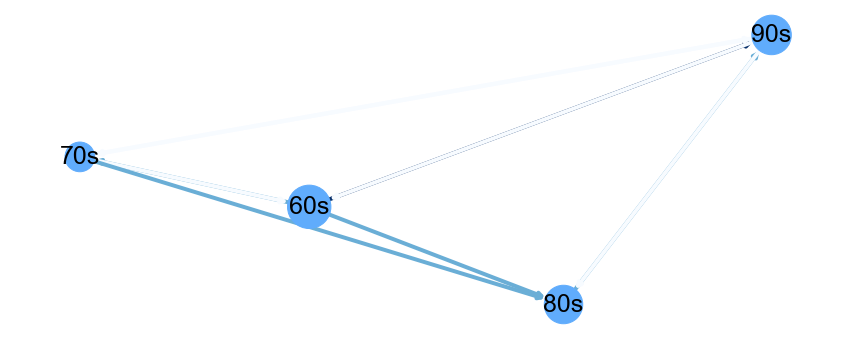

In [35]:
# subnet

A = A_all

# result data
sublist = [65, 85, 105, 125] # sublist为示例节点在矩阵中位置，下同

sub_A = np.zeros((4, 4))

# pos_sub = [(0,0), (1,0), (2,0),(3,0)]

for i in range(len(sublist)):
    for j in range(len(sublist)):
        sub_A[i, j] = A[sublist[i], sublist[j]]

G_sub = nx.from_numpy_matrix(sub_A, create_using=nx.DiGraph()) 

G_sub.remove_nodes_from(list(nx.isolates(G_sub)))

color_list = [float(v['weight']*0.5) for (r,c,v) in G_sub.edges(data=True)]

color_list = [int(((i/max(color_list))*2 + 2)) for i in color_list]

d_sub = {k:v for k,v in d.items() if k in sublist}

plt.figure(figsize=(15, 6))

label = {0: '60s', 1:'70s', 2:'80s', 3:'90s'}

plt.axis("off")
# nx.draw(G, pos, node_color="#A0CBE2", edge_color="#aaaaaa")
nx.draw(G_sub,
#         pos = pos,
        width=4,
        node_color="#60acfc",
        edge_color =color_list,
        edge_cmap=plt.cm.Blues,
#         alpha = 0.5,
        node_size=[v * 40 for v in d_sub.values()],
        # with_labels = False,
        labels = label,
        font_size = 25
       )

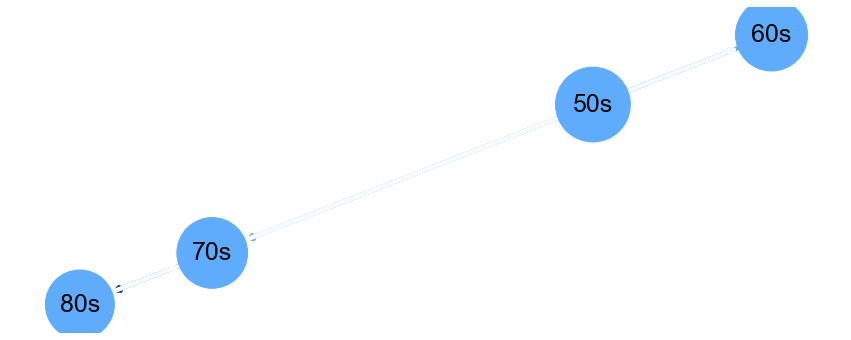

In [36]:
# subnet
A = A_all

sublist = [60, 80, 100, 120]
sub_A = np.zeros((4, 4))

# pos_sub = [(0,0), (1,0), (2,0),(3,0)]

for i in range(len(sublist)):
    for j in range(len(sublist)):
        sub_A[i, j] = A[sublist[i], sublist[j]]

G_sub = nx.from_numpy_matrix(sub_A, create_using=nx.DiGraph()) 

G_sub.remove_nodes_from(list(nx.isolates(G_sub)))

color_list = [float(v['weight']*0.5) for (r,c,v) in G_sub.edges(data=True)]

color_list = [int(((i/max(color_list))*2 + 2)) for i in color_list]

d_sub = {k:v for k,v in d.items() if k in sublist}

plt.figure(figsize=(15, 6))

label = {0: '50s', 1:'60s', 2:'70s', 3:'80s'}

plt.axis("off")
# nx.draw(G, pos, node_color="#A0CBE2", edge_color="#aaaaaa")
nx.draw(G_sub,
#         pos = pos,
        width=4,
        node_color="#60acfc",
        edge_color =color_list,
        edge_cmap=plt.cm.Blues,
#         alpha = 0.5,
        node_size=[v * 40 for v in d_sub.values()],
        # with_labels = False,
        labels = label,
        font_size = 25
       )

## 将fullData 通过不同年份和不同流派分割

In [37]:
# 将fullData 通过不同年份和不同流派分割
minYear = int(min(fullData['year']))

minYear = round(minYear/10)*10

maxYear = int(max(fullData['year']))

maxYear = math.ceil(maxYear/10)*10

fullData['year'] = fullData['year'].astype('int')

# 正常数据
for i in range(6):
    
    _table = pd.DataFrame(columns=fullData.iloc[:, 2:17].columns).drop(columns=['explicit'])
    
    for j in range(int((maxYear - minYear)/10)):
        _data = fullData[(fullData['genre'] == list (genre.keys()) [list (genre.values()).index (i)]) & (fullData['year'] >= minYear + j * 10) & (fullData['year'] < minYear + (j+1) * 10)].iloc[:, 2:17].drop(columns=['explicit'])
        a = _data.astype('float').mean()
        a['year'] = minYear + j * 10
        _table = _table.append(a, ignore_index=True)
    
    pd.DataFrame(sc.fit_transform(_table)).to_csv("./res/"+ list(genre.keys()) [list (genre.values()).index (i)][0:3]+".csv")

_table = pd.DataFrame(columns=fullData.iloc[:, 2:15].columns).drop(columns=['explicit'])
    
for j in range(int((maxYear - minYear))):
    _data = fullData[(fullData['genre'] == list (genre.keys()) [list (genre.values()).index (0)]) & (fullData['year'] == minYear + j) ].iloc[:, 2:17].drop(columns=['explicit'])
    a = _data.astype('float').mean()
    a = a 
    a['year'] = minYear + j
    _table = _table.append(a, ignore_index=True)

pd.DataFrame(sc.fit_transform(_table)).to_csv("./res/"+ list(genre.keys()) [list (genre.values()).index (0)][0:3]+"_1.csv")

# 降维数据
full_ver, full_n_eigVect, full_eigInd = pca(fullData_np, 7)

N_ei = pd.DataFrame(full_n_eigVect)

all_table_7 = pd.DataFrame(columns=fullData.iloc[:, 2:15].columns).drop(columns=['explicit'])

for i in range(6):
    
    _table_7 = pd.DataFrame(columns=fullData.iloc[:, 2:15].columns).drop(columns=['explicit'])
    
    for j in range(int((maxYear - minYear)/10)):
        _data = fullData[(fullData['genre'] == list (genre.keys()) [list (genre.values()).index (i)]) & (fullData['year'] >= minYear + j * 10) & (fullData['year'] < minYear + (j+1) * 10)].iloc[:, 2:15].drop(columns=['explicit'])
        a = _data.astype('float').mean()
        _table_7 = _table_7.append(a, ignore_index=True)
        
    pd.DataFrame(sc.fit_transform(np.dot(sc.fit_transform(_table_7.to_numpy()), full_n_eigVect))).to_csv("./res/"+ list(genre.keys()) [list (genre.values()).index (i)][0:3]+"_7_dim.csv")

    _table_7['genre'] = list (genre.keys()) [list (genre.values()).index (i)]
    all_table_7 = all_table_7.append(_table_7, ignore_index=True)
    
_table_7 = pd.DataFrame(columns=fullData.iloc[:, 2:15].columns).drop(columns=['explicit'])
    
for j in range(int((maxYear - minYear))):
    _data = fullData[(fullData['genre'] == list (genre.keys()) [list (genre.values()).index (2)]) & (fullData['year'] == minYear + j) ].iloc[:, 2:15].drop(columns=['explicit'])
    a = _data.astype('float').mean()
    _table_7 = _table_7.append(a, ignore_index=True)
pd.DataFrame(sc.fit_transform(np.dot(sc.fit_transform(_table_7.to_numpy()), full_n_eigVect))).to_csv("./res/"+ list(genre.keys()) [list (genre.values()).index (2)][0:3]+"_1_7_dim.csv")



### 将分割后的数据进行聚类

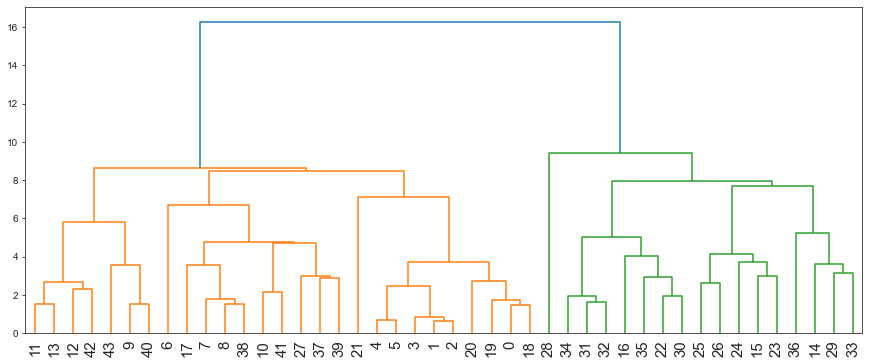

In [38]:
# all_table 聚类

all_table_7 = all_table_7.dropna(how = 'any')

all_table_7_np = all_table_7.drop(columns=['genre']).to_numpy().astype('float')

all_table_7_np = sc.fit_transform(all_table_7_np)

# Convert the palette to vectors that will be drawn on the side of the matrix
# networks = df.columns.get_level_values("network")
# network_colors = pd.Series(networks, index=df.columns).map(network_lut)

# g = sns.clustermap(all_table_7_np, cmap="mako",
#                    col_cluster = False,
#                    figsize=(20, 20),
#                    standard_scale=1
# #                    row_colors=network_colors, col_colors=network_colors,
# #                    dendrogram_ratio=(.1, .2),
# #                    cbar_pos=(.02, .32, .03, .2),
# #                    linewidths=.75, figsize=(12, 13)
#                   )

plt.figure(figsize=(15, 6))

Z = hierarchy.linkage(all_table_7_np, method ='ward',metric='euclidean')

hierarchy.dendrogram(Z, show_leaf_counts=True, leaf_font_size=15., show_contracted=True)

plt.savefig('./img/all_table.jpg', dpi=600)

plt.show()

# _60_art.to_csv('./res/_60_art.csv')

In [39]:
all_table_7

danceability    energy   valence       tempo   loudness      mode  \
4       0.510011  0.600638  0.611809  117.673085  -9.323936  0.787234   
5       0.498949  0.660329  0.545110  124.083754  -9.255037  0.779528   
6       0.484351  0.703225  0.519702  124.752431  -9.715507  0.739570   
7       0.512966  0.726978  0.519593  121.253756  -8.249595  0.762712   
8       0.495254  0.789033  0.465395  128.121005  -5.831603  0.708134   
9       0.491438  0.761577  0.454038  132.264133  -5.710454  0.665138   
10      0.845000  0.455000  0.896000   87.002000 -13.668000  0.000000   
13      0.534894  0.538936  0.737766  122.503000  -9.188468  0.872340   
14      0.563447  0.500184  0.779474  113.249368  -9.549105  0.894737   
15      0.631968  0.605587  0.704190  118.366111  -9.754127  0.603175   
16      0.745582  0.608182  0.739691  118.752527 -11.103418  0.618182   
17      0.678842  0.553789  0.570964  111.900632  -8.965674  0.547368   
18      0.697511  0.603207  0.633474  116.089615  -6.648444  0.622222   
19      0.644323  0.617386  0.441294  115.875441  -6.104787  0.559055   
22      0.270567  0.142800  0.138367   98.159667 -17.282667  0.666667   
24      0.552133  0.345467  0.489533  102.277467 -12.684400  0.800000   
25      0.452500  0.464500  0.520500   92.477000 -10.030500  1.000000   
26      0.697000  0.588000  0.816000  115.339000  -9.416000  1.000000   
27      0.594571  0.617000  0.614417  125.171286  -9.187114  0.942857   
28      0.603500  0.654136  0.552045  130.306818  -6.509364  0.818182   
29      0.479667  0.691000  0.585000  134.136000  -5.779667  1.000000   
31      0.491000  0.489000  0.782000  185.932000  -7.301000  1.000000   
32      0.509050  0.465680  0.564520  113.863350 -11.631500  0.750000   
33      0.545000  0.264282  0.527118  110.269706 -15.450294  0.882353   
34      0.449636  0.283509  0.422091  100.409182 -18.992455  0.363636   
35      0.577667  0.334167  0.505000  115.744167 -17.978000  0.833333   
36      0.481778  0.465444  0.613222  107.522333 -13.605556  1.000000   
37      0.519250  0.581000  0.643750  134.633000 -12.038500  0.500000   
38      0.571000  0.293000  0.230000   82.745000 -11.914000  0.000000   
41      0.331548  0.254355  0.283587   87.966839 -13.172161  0.806452   
42      0.531684  0.374053  0.612842  126.221053  -9.102526  0.736842   
43      0.490812  0.205154  0.438565  114.795388 -15.339694  0.694118   
44      0.450756  0.293785  0.472195  108.757000 -13.077488  0.731707   
45      0.349000  0.140000  0.114000   78.211000 -13.435000  1.000000   
46      0.438350  0.302775  0.420150  124.701600 -10.164200  0.600000   
47      0.421500  0.296675  0.468375   97.604750 -12.891750  1.000000   
48      0.367500  0.198500  0.206900   79.803000 -15.632500  0.000000   
53      0.615200  0.707767  0.797233  114.992633  -9.704200  0.766667   
54      0.532595  0.521926  0.685703  106.102041 -10.633000  0.702703   
55      0.637222  0.521022  0.704778  105.534111 -11.522889  0.444444   
56      0.637714  0.565143  0.703929  116.819571 -12.235571  0.571429   
57      0.638579  0.680842  0.841421  124.479947  -8.378947  0.578947   
58      0.675450  0.809000  0.806600  114.123900  -5.870050  0.450000   
59      0.682000  0.645800  0.781400  103.365600  -7.052000  0.800000   

         key  acousticness  instrumentalness  liveness  speechiness  \
4   4.691489      0.301912      1.327142e-01  0.169524     0.044448   
5   5.444882      0.245587      7.476029e-02  0.238011     0.060103   
6   5.446271      0.158136      1.066445e-01  0.242319     0.052600   
7   5.696610      0.128442      7.191798e-02  0.215698     0.058471   
8   5.328549      0.093754      4.960638e-02  0.201319     0.065019   
9   5.027523      0.139706      3.600287e-02  0.178859     0.071128   
10  5.000000      0.710000      4.200000e-01  0.055000     0.048800   
13  5.021277      0.710851      1.991644e-02  0.236426     0.064198   
14  5.184211      0.463677      3.170762e-02  0.183237     0.043334   
15  4.23

In [40]:
# only year 7dim
_table_7 = pd.DataFrame(columns=fullData.iloc[:, 2:15].columns).drop(columns=['explicit'])

# for j in range(int((maxYear - minYear))):
#     _data = fullData[(fullData['year'] == minYear + j) ].iloc[:, 2:15].drop(columns=['explicit'])
#     a = _data.astype('float').mean()
#     _table_7 = _table_7.append(a, ignore_index=True)
# pd.DataFrame(sc.fit_transform(np.dot(sc.fit_transform(_table_7.to_numpy()), n_eigVect))).to_csv("./res/only_year_1_7_dim.csv")

for j in range(int((maxYear - minYear))):
    _data = fullData[(fullData['year'] == minYear + j) ].iloc[:, 2:17].drop(columns=['explicit'])
    a = _data.astype('float').mean()
    _table_7 = _table_7.append(a, ignore_index=True)
pd.DataFrame(sc.fit_transform(_table_7)).to_csv("./res/only_year_1.csv")

print(minYear)
print(maxYear)

1920
2020


In [41]:
_table_7

danceability    energy   valence       tempo   loudness      mode  \
0            NaN       NaN       NaN         NaN        NaN       NaN   
1       0.375500  0.189100  0.497000  143.028500 -19.281500  1.000000   
2            NaN       NaN       NaN         NaN        NaN       NaN   
3            NaN       NaN       NaN         NaN        NaN       NaN   
4            NaN       NaN       NaN         NaN        NaN       NaN   
..           ...       ...       ...         ...        ...       ...   
95      0.551600  0.748667  0.435400  133.508367  -5.731433  0.566667   
96      0.545438  0.594771  0.408367  124.871021  -6.725229  0.520833   
97      0.559312  0.525562  0.357694  104.157375  -8.241875  0.687500   
98      0.626867  0.642667  0.437063  124.956133  -5.645967  0.600000   
99      0.640562  0.667250  0.455562  120.366094  -5.478594  0.500000   

         key  acousticness  instrumentalness  liveness  speechiness  \
0        NaN           NaN               NaN       NaN          NaN   
1   3.000000      0.992500          0.348850  0.392500     0.040650   
2        NaN           NaN               NaN       NaN          NaN   
3        NaN           NaN               NaN       NaN          NaN   
4        NaN           NaN               NaN       NaN          NaN   
..       ...           ...               ...       ...          ...   
95  5.333333      0.189709          0.087961  0.149543     0.070517   
96  4.979167      0.212169          0.045550  0.182438     0.078935   
97  4.562500      0.370814          0.106248  0.106694     0.075787   
98  5.500000      0.148426          0.001239  0.140463     0.101160   
99  5.375000      0.197259          0.027583  0.186488     0.128491   

      duration_ms  popularity    year  
0             NaN         NaN     NaN  
1   234687.000000    0.000000  1921.0  
2             NaN         NaN     NaN  
3             NaN         NaN     NaN  
4             NaN         NaN     NaN  
..            ...         ...     ...  
95  227212.833333   59.733333  2015.0  
96  238696.958333   63.604167  2016.0  
97  240457.250000   66.250000  2017.0  
98  190478.266667   69.366667  2018.0  
99  200105.812500   71.812500  2019.0  

[100 rows x 14 columns]

## 12类数据的相关矩阵作图

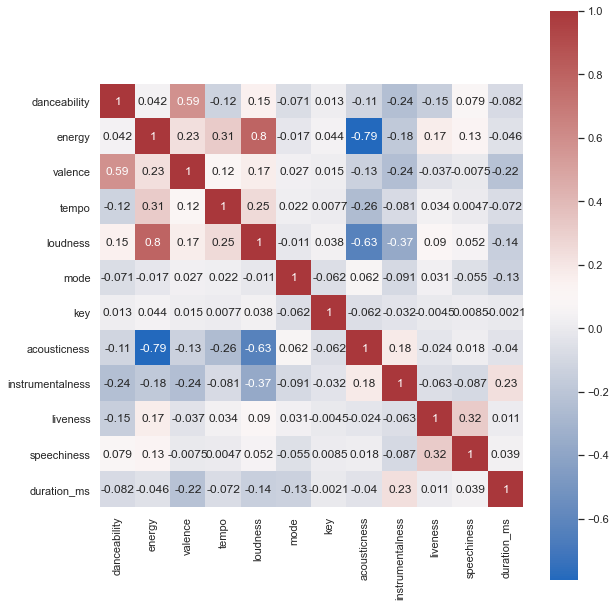

In [44]:
sns.set_theme(style="whitegrid")

# result data
a = np.loadtxt('./data/our_data/相关系数.txt') # 12类数据的相关系数矩阵

a = pd.DataFrame(a)
a.index = artistData.drop(columns=['artist_name', 'artist_id', 'count', 'popularity', 'genre']).columns
a.columns = a.index

plt.figure(figsize=(9,9))

g = sns.heatmap(data = a, cmap="vlag", square=True, annot=True)

plt.tight_layout()

plt.savefig('./img/相关系数.jpg', dpi = 600)